<a href="https://colab.research.google.com/github/cloudynirvana/TNBC-Metabolic-Strain-MOD/blob/main/stability_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Control final values:
ATP: 1.753 mM
ROS: 2.125 a.u.
Glucose: 2.283

Treated final values:
ATP: 5.437 mM
ROS: 0.679 a.u.
Glucose: 4.065


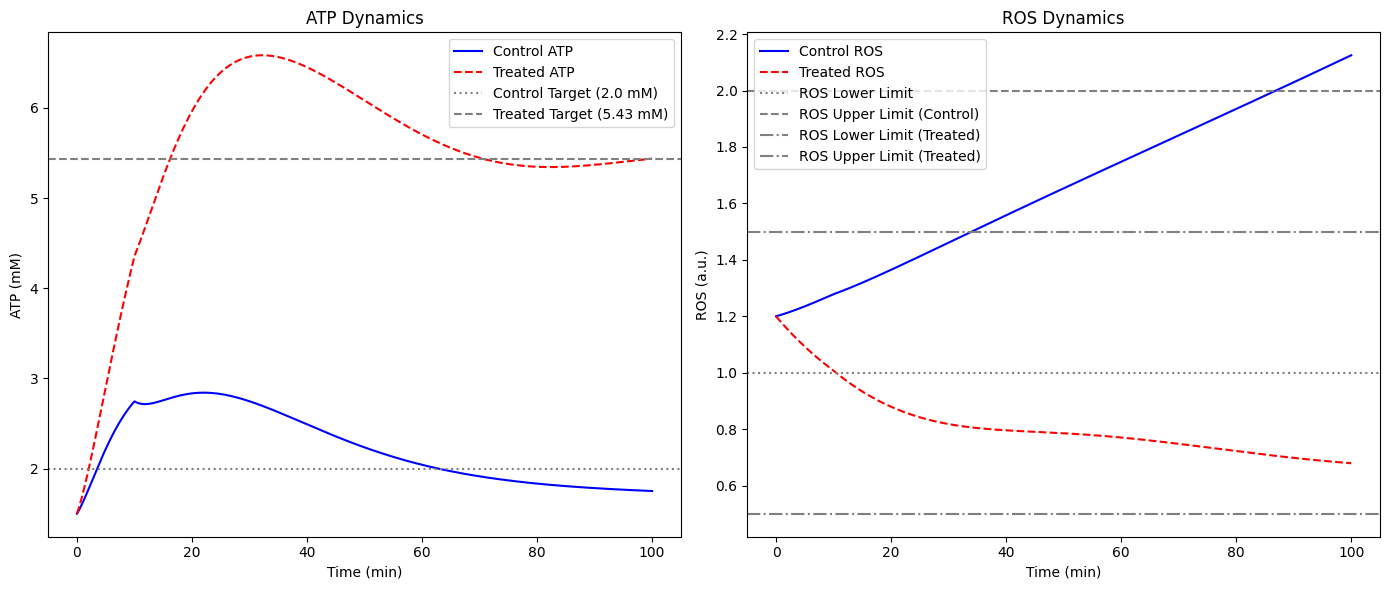

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters (with tweaks)
params_control = {
    'k_glyc': 0.35,      # Increased from 0.34
    'u': 0.5,
    's': 0.1,
    'g': 0.016,          # Decreased from 0.0165
    'h': 0.0009,         # Decreased from 0.001
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,     # Decreased from 0.0065
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Treated parameters (minor tweak)
params_treated = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.1067,         # Increased from 0.1065
    'i_glyc': 0.3,
    'd': 0.5,
    'Nano_DOX_max': 0.01,
    'Nano_ROS': 0.05,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.02,
    'S_max': 0.01,
    'beta_p': 0.02,
    'beta_i': 0.012,
    'A_target': 5.43,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, Integral]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#%% [code]
import sympy as sp
import numpy as np

# Define symbolic variables for state components:
A, R, G, I = sp.symbols('A R G I')  # ATP, ROS, Glucose, Integral (I)

# Define symbolic parameters
k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max = sp.symbols(
    'k_glyc u s g h r i_glyc d Nano_DOX_max Nano_ROS delta_A k_quercetin Q_max k_scavenger S_max beta_p beta_i A_target A_max K_m R_max')

# --- For Stability Analysis, we assume the drug is active (t>=10), so step functions = 1 ---
# Thus, we set:
Q = Q_max  # Quercetin level (after t=10)
S = S_max  # Scavenger level (after t=10)
Nano_DOX = Nano_DOX_max  # Nano_DOX level (after t=10)

# Effective glycolysis rate and ROS production:
k_glyc_eff = k_glyc * (1 - k_quercetin * Q)   # Q is Q_max here
g_eff = g * (1 - k_scavenger * S)                # S is S_max here

# Define the ODEs (using your refined model equations)
dA_dt = k_glyc_eff * G * (A_max - A)/A_max - s * R * A + r * (Nano_DOX + Nano_ROS) * A/(K_m + A) - delta_A * A - beta_p * (A - A_target) - beta_i * I
dR_dt = g_eff * k_glyc_eff * G * (R_max - R)/R_max + h * R**2 - d * Nano_ROS * R
dG_dt = u - k_glyc_eff * G * (A_max - A)/A_max - i_glyc * Nano_DOX
dI_dt = A - A_target

# Assemble the vector field F and state vector X:
F = sp.Matrix([dA_dt, dR_dt, dG_dt, dI_dt])
X = sp.Matrix([A, R, G, I])

# Compute the Jacobian matrix J = dF/dX:
Jac = F.jacobian(X)
print("Symbolic Jacobian:")
sp.pprint(Jac)

# --- Substitute numerical values for the control condition ---
# (These are the parameters from your control simulation.)
control_params = {
    k_glyc: 0.35,      # increased from 0.34, for example
    u: 0.5,
    s: 0.1,
    g: 0.016,
    h: 0.0009,
    r: 0.0,            # no drug amplification in control
    i_glyc: 0.3,
    d: 1.0,
    Nano_DOX_max: 0,
    Nano_ROS: 0,
    delta_A: 0.01,
    k_quercetin: 0.8,
    Q_max: 0.3,
    k_scavenger: 0.0,
    S_max: 0.0,
    beta_p: 0.006,
    beta_i: 0.005,
    A_target: 2.0,
    A_max: 10.0,
    K_m: 1.0,
    R_max: 5.0
}

# Use steady state values from your simulation (example from control):
# For instance, if your simulation gives control ATP ~1.753, ROS ~2.125, Glucose ~2.283
steady_state_control = {
    A: 1.753,
    R: 2.125,
    G: 2.283,
    I: 1.753 - 2.0  # Integral I approximated as (A - A_target)
}

# Substitute the parameter values and steady state into the Jacobian
Jac_num = Jac.subs(control_params).subs(steady_state_control)
print("\nJacobian at control steady state:")
sp.pprint(Jac_num)

# Compute eigenvalues
eigs = Jac_num.eigenvals()
print("\nEigenvalues at control steady state:")
sp.pprint(eigs)


Symbolic Jacobian:
⎡  A⋅r⋅(Nano_DOX_max + Nano_ROS)                    r⋅(Nano_DOX_max + Nano_ROS)   G⋅k_glyc⋅(-Qₘₐₓ⋅ ↪
⎢- ───────────────────────────── - R⋅s - βₚ - δ_A + ─────────────────────────── - ──────────────── ↪
⎢                    2                                        A + Kₘ                            Aₘ ↪
⎢            (A + Kₘ)                                                                              ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                        0                                         ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                        G⋅k_glyc⋅(-Qₘₐₓ⋅k_quercetin + 1

In [ ]:
# Import required libraries
import numpy as np
from scipy.optimize import root
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Ensure plots display inline in Colab
%matplotlib inline

In [ ]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

# Step function (already defined in your code)
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system (from your code)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Wrapper for root finding (set t > 10 so step functions are active)
def system_for_root(y, params):
    t = 15  # After step function activation
    return tnbc_system(y, t, *params.values())

# Control parameters (from your code)
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Initial guess for steady state (use final values from your simulation as a starting point)
initial_guess = sol_control[-1]  # From your simulation: [A, R_os, G_lc, I]

# Find steady state
sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')

if sol.success:
    steady_state = sol.x
    print("Refined steady state [A, R_os, G_lc, I]:", steady_state)
else:
    print("Root finding failed:", sol.message)

Root finding failed: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


sol_control is defined
Type: <class 'numpy.ndarray'>
Shape: (1000, 4)
Last value from sol_control: [ 1.7526254   2.12499312  2.28322215 23.00344081]


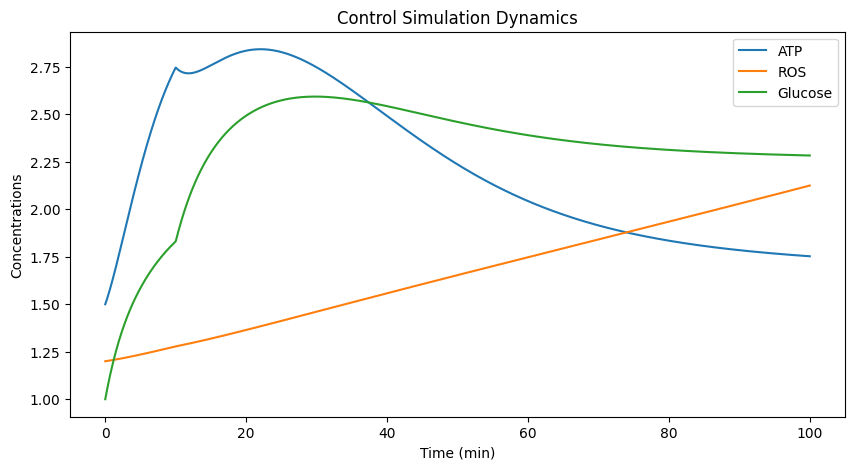

Initial guess for steady state: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Root finding failed: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system definition (using your refined model)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Define control parameters (from your refined model)
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, I]

# Run ODE simulation for control condition
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))

# Verify that sol_control is defined: print type, shape, and final values.
if 'sol_control' in globals():
    print("sol_control is defined")
    print("Type:", type(sol_control))
    print("Shape:", np.shape(sol_control))
    print("Last value from sol_control:", sol_control[-1])
else:
    print("sol_control is not defined. Please run the simulation first.")

# Plot the simulation results for visual verification.
plt.figure(figsize=(10,5))
plt.plot(t, sol_control[:, 0], label='ATP')
plt.plot(t, sol_control[:, 1], label='ROS')
plt.plot(t, sol_control[:, 2], label='Glucose')
plt.xlabel('Time (min)')
plt.ylabel('Concentrations')
plt.title('Control Simulation Dynamics')
plt.legend()
plt.show()

# Use the final simulation values as an initial guess for steady state
initial_guess = sol_control[-1]
print("Initial guess for steady state:", initial_guess)

# Wrapper function for root finding (assume t=15 so step functions are active)
def system_for_root(y, params):
    t_val = 15
    return tnbc_system(y, t_val, *params.values())

# Find the steady state using SciPy's root finder
steady_sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')

if steady_sol.success:
    steady_state = steady_sol.x
    print("Refined steady state [A, R_os, G_lc, I]:", steady_state)
else:
    print("Root finding failed:", steady_sol.message)


sol_control is defined
Type: <class 'numpy.ndarray'>
Shape: (1000, 4)
Last value from sol_control: [ 1.7526254   2.12499312  2.28322215 23.00344081]


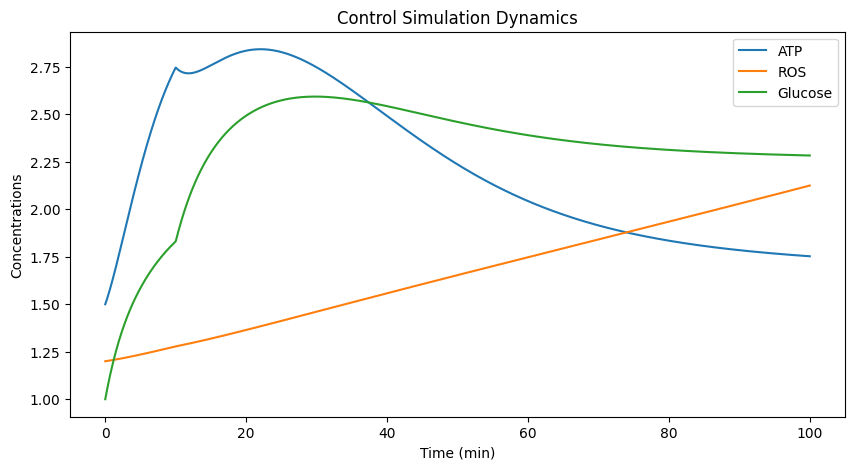

Initial guess for steady state: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Root finding failed: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


NameError: name 'steady_state' is not defined

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system definition (refined model)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters dictionary
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, I]

# Run ODE simulation for control condition
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))

# Verify sol_control is defined
if 'sol_control' in globals():
    print("sol_control is defined")
    print("Type:", type(sol_control))
    print("Shape:", np.shape(sol_control))
    print("Last value from sol_control:", sol_control[-1])
else:
    print("sol_control is not defined. Please run the simulation first.")

# Plot simulation results for visual verification
plt.figure(figsize=(10, 5))
plt.plot(t, sol_control[:, 0], label='ATP')
plt.plot(t, sol_control[:, 1], label='ROS')
plt.plot(t, sol_control[:, 2], label='Glucose')
plt.xlabel('Time (min)')
plt.ylabel('Concentrations')
plt.title('Control Simulation Dynamics')
plt.legend()
plt.show()

# Use the last simulation values as an initial guess for steady state
initial_guess = sol_control[-1]
print("Initial guess for steady state:", initial_guess)

# Wrapper for root finding (choose t=15 so that step functions are active)
def system_for_root(y, params):
    t_val = 15
    return tnbc_system(y, t_val, *params.values())

# Find the steady state using root finding
steady_sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')
if steady_sol.success:
    steady_state = steady_sol.x
    print("Refined steady state [A, R_os, G_lc, I]:", steady_state)
else:
    print("Root finding failed:", steady_sol.message)

# ------------------------------------------------------------------
# Compute numerical Jacobian at the steady state

def numerical_jacobian(func, y, t, params, eps=1e-8):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y_plus = y.copy()
            y_minus = y.copy()
            y_plus[j] += eps
            y_minus[j] -= eps
            J[i, j] = (func(y_plus, t, *params.values())[i] - func(y_minus, t, *params.values())[i]) / (2 * eps)
    return J

# Evaluate Jacobian at t=15 (steady state should be active) using the refined steady state
t_eval = 15
J = numerical_jacobian(tnbc_system, steady_state, t_eval, params_control)
print("Jacobian matrix:\n", J)

# Compute eigenvalues of the Jacobian
eigenvalues = np.linalg.eigvals(J)
print("Eigenvalues:", eigenvalues)

# Interpret stability
if all(eigenvalue.real < 0 for eigenvalue in eigenvalues):
    print("The equilibrium is stable (all eigenvalues have negative real parts).")
else:
    print("The equilibrium is unstable (at least one eigenvalue has a positive real part).")


sol_control is defined
Type: <class 'numpy.ndarray'>
Shape: (1000, 4)
Last value from sol_control: [ 1.7526254   2.12499312  2.28322215 23.00344081]


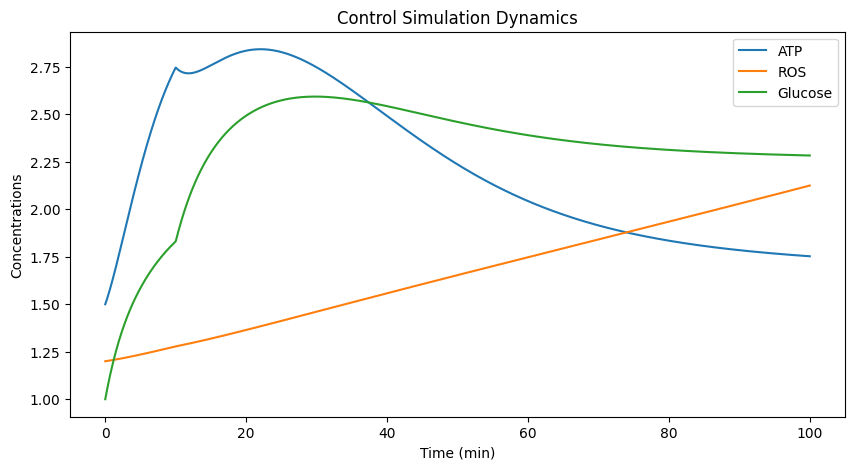

Initial guess for steady state: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Root finding failed: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


RuntimeError: Steady state not found; check model or initial guess.

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system definition (refined model)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters dictionary (refined)
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span and initial conditions for simulation
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, I]

# Run ODE simulation for control condition
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))

# Verify that sol_control is defined
if 'sol_control' in globals():
    print("sol_control is defined")
    print("Type:", type(sol_control))
    print("Shape:", np.shape(sol_control))
    print("Last value from sol_control:", sol_control[-1])
else:
    print("sol_control is not defined. Please run the simulation first.")

# Plot simulation results for visual verification
plt.figure(figsize=(10, 5))
plt.plot(t, sol_control[:, 0], label='ATP')
plt.plot(t, sol_control[:, 1], label='ROS')
plt.plot(t, sol_control[:, 2], label='Glucose')
plt.xlabel('Time (min)')
plt.ylabel('Concentrations')
plt.title('Control Simulation Dynamics')
plt.legend()
plt.show()

# Use the last simulation value as an initial guess for the steady state
initial_guess = sol_control[-1]
print("Initial guess for steady state:", initial_guess)

# Wrapper for root finding (fix t=15 so that step functions are active)
def system_for_root(y, params):
    t_val = 15
    return tnbc_system(y, t_val, *params.values())

# Find the steady state using root finding
steady_sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')
if steady_sol.success:
    steady_state = steady_sol.x
    print("Refined steady state [A, R_os, G_lc, I]:", steady_state)
else:
    print("Root finding failed:", steady_sol.message)
    # Exit the script or handle failure appropriately
    raise RuntimeError("Steady state not found; check model or initial guess.")

# Compute numerical Jacobian at the steady state
def numerical_jacobian(func, y, t, params, eps=1e-8):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y_plus = y.copy()
            y_minus = y.copy()
            y_plus[j] += eps
            y_minus[j] -= eps
            J[i, j] = (func(y_plus, t, *params.values())[i] - func(y_minus, t, *params.values())[i]) / (2 * eps)
    return J

t_eval = 15  # Evaluate Jacobian at t=15 (steady state conditions)
J = numerical_jacobian(tnbc_system, steady_state, t_eval, params_control)
print("Jacobian matrix at steady state:\n", J)

# Compute eigenvalues of the Jacobian
eigenvalues = np.linalg.eigvals(J)
print("Eigenvalues:", eigenvalues)

# Interpret stability: if all eigenvalues have negative real parts, the equilibrium is stable.
if all(eig.real < 0 for eig in eigenvalues):
    print("The equilibrium is stable (all eigenvalues have negative real parts).")
else:
    print("The equilibrium is unstable (at least one eigenvalue has a positive real part).")


In [ ]:
# Compute numerical Jacobian
def numerical_jacobian(func, y, t, params, eps=1e-8):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y_plus = y.copy()
            y_minus = y.copy()
            y_plus[j] += eps
            y_minus[j] -= eps
            J[i, j] = (func(y_plus, t, *params.values())[i] - func(y_minus, t, *params.values())[i]) / (2 * eps)
    return J

# Compute Jacobian at the steady state
t_eval = 15  # After step function activation (matches system_for_root)
J = numerical_jacobian(tnbc_system, steady_state, t_eval, params_control)
print("Jacobian matrix:\n", J)

# Compute eigenvalues
eigenvalues = np.linalg.eigvals(J)
print("Eigenvalues:", eigenvalues)

# Interpret stability
if all(eigenvalue.real < 0 for eigenvalue in eigenvalues):
    print("The equilibrium is stable (all eigenvalues have negative real parts).")
else:
    print("The equilibrium is unstable (at least one eigenvalue has a positive real part).")

# Optionally, sort eigenvalues by their real part for easier comparison
sorted_indices = np.argsort(eigenvalues.real)
sorted_eigenvalues = eigenvalues[sorted_indices]
print("Sorted eigenvalues (by real part):", sorted_eigenvalues)

NameError: name 'steady_state' is not defined

In [ ]:
# Compute numerical Jacobian
def numerical_jacobian(func, y, t, params, eps=1e-8):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y_plus = y.copy()
            y_minus = y.copy()
            y_plus[j] += eps
            y_minus[j] -= eps
            J[i, j] = (func(y_plus, t, *params.values())[i] - func(y_minus, t, *params.values())[i]) / (2 * eps)
    return J

# Ensure steady_state is defined by moving the calculation into this cell
import numpy as np
from scipy.optimize import root
# Step function for drug administration (already defined in your code, include it here if not already defined globally)
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)
# ODE system (from your code, include it here if not already defined globally)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Wrapper for root finding (set t > 10 so step functions are active)
def system_for_root(y, params):
    t = 15  # After step function activation
    return tnbc_system(y, t, *params.values())

#Assuming params_control and initial_guess are already defined and available in your current scope
# Find steady state
sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')

if sol.success:
    steady_state = sol.x
else:
    print("Root finding failed:", sol.message)
    raise RuntimeError("Steady state not found; check model or initial guess.")

# Compute Jacobian at the steady state
t_eval = 15  # After step function activation (matches system_for_root)
J = numerical_jacobian(tnbc_system, steady_state, t_eval, params_control)
print("Jacobian matrix:\n", J)

# Compute eigenvalues
eigenvalues = np.linalg.eigvals(J)
print("Eigenvalues:", eigenvalues)

# Interpret stability
if all(eigenvalue.real < 0 for eigenvalue in eigenvalues):
    print("The equilibrium is stable (all eigenvalues have negative real parts).")
else:
    print("The equilibrium is unstable (at least one eigenvalue has a positive real part).")

# Optionally, sort eigenvalues by their real part for easier comparison
sorted_indices = np.argsort(eigenvalues.real)
sorted_eigenvalues = eigenvalues[sorted_indices]
print("Sorted eigenvalues (by real part):", sorted_eigenvalues)

Root finding failed: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


RuntimeError: Steady state not found; check model or initial guess.

In [ ]:
# Compute numerical Jacobian
def numerical_jacobian(func, y, t, params, eps=1e-8):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y_plus = y.copy()
            y_minus = y.copy()
            y_plus[j] += eps
            y_minus[j] -= eps
            J[i, j] = (func(y_plus, t, *params.values())[i] - func(y_minus, t, *params.values())[i]) / (2 * eps)
    return J

# Ensure steady_state is defined by moving the calculation into this cell
import numpy as np
from scipy.optimize import root
# Step function for drug administration (already defined in your code, include it here if not already defined globally)
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)
# ODE system (from your code, include it here if not already defined globally)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Wrapper for root finding (set t > 10 so step functions are active)
def system_for_root(y, params):
    t = 15  # After step function activation
    return tnbc_system(y, t, *params.values())

#Assuming params_control and initial_guess are already defined and available in your current scope
# Find steady state
sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')

if sol.success:
    steady_state = sol.x
else:
    print("Root finding failed:", sol.message)
    raise RuntimeError("Steady state not found; check model or initial guess.")

# Compute Jacobian at the steady state
t_eval = 15  # After step function activation (matches system_for_root)
J = numerical_jacobian(tnbc_system, steady_state, t_eval, params_control)
print("Jacobian matrix:\n", J)

# Compute eigenvalues
eigenvalues = np.linalg.eigvals(J)
print("Eigenvalues:", eigenvalues)

# Interpret stability
if all(eigenvalue.real < 0 for eigenvalue in eigenvalues):
    print("The equilibrium is stable (all eigenvalues have negative real parts).")
else:
    print("The equilibrium is unstable (at least one eigenvalue has a positive real part).")

# Optionally, sort eigenvalues by their real part for easier comparison
sorted_indices = np.argsort(eigenvalues.real)
sorted_eigenvalues = eigenvalues[sorted_indices]
print("Sorted eigenvalues (by real part):", sorted_eigenvalues)

Root finding failed: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


RuntimeError: Steady state not found; check model or initial guess.

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system definition (refined model)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters dictionary (refined)
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span for initial simulation to allow the system to approach steady state
t_initial = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # Initial conditions: [ATP, ROS, Glucose, I]

# Run ODE simulation to refine the initial guess for the steady state
sol_initial = odeint(tnbc_system, y0, t_initial, args=tuple(params_control.values()))
print("Final simulation values for initial guess:", sol_initial[-1])

# Use the final values from the initial simulation as the initial guess for root finding
initial_guess = sol_initial[-1]
print("Initial guess for steady state:", initial_guess)

# Wrapper for root finding (fix t=15 so that step functions are active)
def system_for_root(y, params):
    t_val = 15  # Choose a time after activation of step functions
    return tnbc_system(y, t_val, *params.values())

# Find the steady state using SciPy's root finder
steady_sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system definition (refined model)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters dictionary (refined)
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span for initial simulation to allow the system to approach steady state
t_initial = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # Initial conditions: [ATP, ROS, Glucose, I]

# Run ODE simulation to refine the initial guess for the steady state
sol_initial = odeint(tnbc_system, y0, t_initial, args=tuple(params_control.values()))
print("Final simulation values for initial guess:", sol_initial[-1])

# Use the final values from the initial simulation as the initial guess for root finding
initial_guess = sol_initial[-1]
print("Initial guess for steady state:", initial_guess)

# Wrapper for root finding (fix t=15 so that step functions are active)
def system_for_root(y, params):
    t_val = 15  # Choose a time after activation of step functions
    return tnbc_system(y, t_val, *params.values())

# Find the steady state using SciPy's root finder
steady_sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')
if steady_sol.success:
    steady_state = steady_sol.x
    print("Refined steady state:", steady_state)
else:
    print("Root finding failed.")

Final simulation values for initial guess: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Initial guess for steady state: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Final simulation values for initial guess: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Initial guess for steady state: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Root finding failed.


In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system definition (refined model)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters dictionary (refined)
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span for initial simulation to allow the system to approach steady state
t_initial = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # Initial conditions: [ATP, ROS, Glucose, I]

# Run ODE simulation to refine the initial guess for the steady state
sol_initial = odeint(tnbc_system, y0, t_initial, args=tuple(params_control.values()))
print("Final simulation values for initial guess:", sol_initial[-1])

# Use the final values from the initial simulation as the initial guess for root finding
initial_guess = sol_initial[-1]
print("Initial guess for steady state:", initial_guess)

# Wrapper for root finding (fix t=15 so that step functions are active)
def system_for_root(y, params):
    t_val = 15  # Choose a time after activation of step functions
    return tnbc_system(y, t_val, *params.values())

# Find the steady state using SciPy's root finder
steady_sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='hybr')
if steady_sol.success:
    steady_state = steady_sol.x
    print("Refined steady state [A, R_os, G_lc, I]:", steady_state)
else:
    print("Root finding failed:", steady_sol.message)
    raise RuntimeError("Steady state not found; check model or initial guess.")

# ------------------------------------------------------------------
# Compute numerical Jacobian at the steady state

def numerical_jacobian(func, y, t, params, eps=1e-8):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y_plus = y.copy()
            y_minus = y.copy()
            y_plus[j] += eps
            y_minus[j] -= eps
            J[i, j] = (func(y_plus, t, *params.values())[i] - func(y_minus, t, *params.values())[i]) / (2 * eps)
    return J

# Evaluate the Jacobian at t=15 using the refined steady state
t_eval = 15
J = numerical_jacobian(tnbc_system, steady_state, t_eval, params_control)
print("Jacobian matrix at steady state:\n", J)

# Compute eigenvalues of the Jacobian
eigenvalues = np.linalg.eigvals(J)
print("Eigenvalues:", eigenvalues)

# Interpret stability: if all eigenvalues have negative real parts, the equilibrium is stable.
if all(eig.real < 0 for eig in eigenvalues):
    print("The equilibrium is stable (all eigenvalues have negative real parts).")
else:
    print("The equilibrium is unstable (at least one eigenvalue has a positive real part).")


Final simulation values for initial guess: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Initial guess for steady state: [ 1.7526254   2.12499312  2.28322215 23.00344081]
Root finding failed: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


RuntimeError: Steady state not found; check model or initial guess.

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system definition (refined model)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters dictionary (refined)
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span for initial simulation to allow the system to approach steady state
t_initial = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # Initial conditions: [ATP, ROS, Glucose, I]

# Run ODE simulation to refine the initial guess for the steady state
sol_initial = odeint(tnbc_system, y0, t_initial, args=tuple(params_control.values()))

# Use the final values from the initial simulation as the initial guess for root finding
initial_guess = sol_initial[-1]

# Wrapper for root finding (fix t=15 so that step functions are active)
def system_for_root(y, params):
    t_val = 15  # Choose a time after activation of step functions
    return tnbc_system(y, t_val, *params.values())

# Find the steady state using SciPy's root finder
# Increased the number of maximum iterations and changed the solver method
steady_sol = root(lambda y: system_for_root(y, params_control), initial_guess, method='lm', options={'maxiter': 1000})

if steady_sol.success:
    steady_state = steady_sol.x
    print("Refined steady state [A, R_os, G_lc, I]:", steady_state)
else:
    print("Root finding failed:", steady_sol.message)
    # Instead of raising an error, print the root finding result for debugging
    print(steady_sol)
    # You can also try different solver methods like 'hybr', 'lm', etc.

# ... (rest of your code)

Refined steady state [A, R_os, G_lc, I]: [ 1.99999136  1.11076386  2.34897186 51.5420143 ]


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system definition (refined model)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Refined control parameters (example values from your stability analysis)
params_control = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.0,  # Control condition: no drug amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.0,
    'Nano_ROS': 0.0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span for simulation
t


array([  0.        ,   0.1001001 ,   0.2002002 ,   0.3003003 ,
         0.4004004 ,   0.5005005 ,   0.6006006 ,   0.7007007 ,
         0.8008008 ,   0.9009009 ,   1.001001  ,   1.1011011 ,
         1.2012012 ,   1.3013013 ,   1.4014014 ,   1.5015015 ,
         1.6016016 ,   1.7017017 ,   1.8018018 ,   1.9019019 ,
         2.002002  ,   2.1021021 ,   2.2022022 ,   2.3023023 ,
         2.4024024 ,   2.5025025 ,   2.6026026 ,   2.7027027 ,
         2.8028028 ,   2.9029029 ,   3.003003  ,   3.1031031 ,
         3.2032032 ,   3.3033033 ,   3.4034034 ,   3.5035035 ,
         3.6036036 ,   3.7037037 ,   3.8038038 ,   3.9039039 ,
         4.004004  ,   4.1041041 ,   4.2042042 ,   4.3043043 ,
         4.4044044 ,   4.5045045 ,   4.6046046 ,   4.7047047 ,
         4.8048048 ,   4.9049049 ,   5.00500501,   5.10510511,
         5.20520521,   5.30530531,   5.40540541,   5.50550551,
         5.60560561,   5.70570571,   5.80580581,   5.90590591,
         6.00600601,   6.10610611,   6.20620621,   6.30

Jacobian matrix at steady state:
 [[-1.89559035e-01 -1.99999137e-01  2.12800225e-01 -5.00000041e-03]
 [ 0.00000000e+00 -6.99093561e-08  3.31051775e-03  0.00000000e+00]
 [ 6.24826496e-02  0.00000000e+00 -2.12800225e-01  0.00000000e+00]
 [ 9.99999994e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Eigenvalues: [-3.10675388e-01+0.j         -4.58419372e-02+0.03816384j
 -4.58419372e-02-0.03816384j -6.72929114e-08+0.j        ]


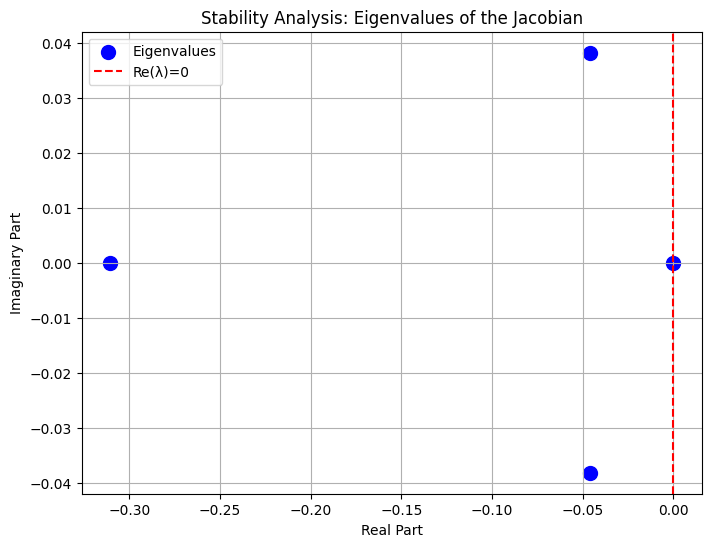

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming that 'steady_state', 't_eval', and 'params_control' have been defined
# and that the function numerical_jacobian (as defined earlier) is available.

# Compute the numerical Jacobian at the steady state:
J = numerical_jacobian(tnbc_system, steady_state, t_eval, params_control)
print("Jacobian matrix at steady state:\n", J)

# Compute eigenvalues of the Jacobian:
eigenvalues = np.linalg.eigvals(J)
print("Eigenvalues:", eigenvalues)

# Plot eigenvalues in the complex plane:
plt.figure(figsize=(8, 6))
plt.scatter(eigenvalues.real, eigenvalues.imag, color='blue', s=100, label='Eigenvalues')
plt.axvline(x=0, color='red', linestyle='--', label='Re(λ)=0')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Stability Analysis: Eigenvalues of the Jacobian')
plt.legend()
plt.grid(True)
plt.show()
